# Spotify Artist Explorer

A simple Jupyter notebook that uses [Spotify's API](https://developer.spotify.com/) to retrieve an inputted artist' albums, from which the user selects an album and a track to generate a wordcloud of the lyrics (without stopwords), with the lyrics retrieved via the API of [lyrics.ovh](https://lyrics.ovh/).

Uses `ipywidgets` package to display user inputs when the notebook is run so please execute each code block one after another, after filling the requested fields for each.

In [1]:
# Import required libraries and request user's Spotify API credentials

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import ipywidgets as widgets
from IPython.display import display

client_id_input = widgets.Text(
    description='Client ID:',
    placeholder='Enter your Spotify Client ID'
)

client_secret_input = widgets.Text(
    description='Client Secret:',
    placeholder='Enter your Spotify Client Secret'
)

display(client_id_input)
display(client_secret_input)

Text(value='', description='Client ID:', placeholder='Enter your Spotify Client ID')

Text(value='', description='Client Secret:', placeholder='Enter your Spotify Client Secret')

In [5]:
# Open connection to Spotify API via Spotipy package

client_id = client_id_input.value
client_secret = client_secret_input.value

try:
  client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
  sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

  print("Successfully connected to Spotify API")
except Exception as e:
  print(f"Error connecting to Spotify API: {e}")

Successfully connected to Spotify API


In [6]:
# Functions to get artist albums, album tracks, and track lyrics

def get_artist_albums(artist_name):
    results = sp.search(q=f'artist:{artist_name}', type='artist')
    artists = results['artists']['items']
    
    if not artists:
        raise Exception(f"No artist found with name {artist_name}")
    
    artist = artists[0]
    artist_id = artist['id']
    albums = []

     # Filter for albums only (sometimes includes concert recordings, remasters, etc. but the only reliable method I found 
     # of removing them was with a keyword search, which also frequently removed legitimate albums, so I chose to keep them)
    results = sp.artist_albums(artist_id, album_type='album')
    albums.extend(results['items'])
    
    # Retrieve more albums if there is a next page
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])
                
    return {album['name']: album['id'] for album in albums}

def get_album_tracks(album_id):
    results = sp.album_tracks(album_id)
    tracks = results['items']
    return [track['name'] for track in tracks]

def get_track_lyrics(artist_name, track_name):
    response = requests.get(f"https://api.lyrics.ovh/v1/{artist_name}/{track_name}")
    response.raise_for_status()
    data = response.json()
    return data.get("lyrics", "Lyrics not found.")

In [8]:
# User input for artist name

artist_input = widgets.Text(
    description='Artist:',
    placeholder='Enter artist name',
    style={'description_width': 'initial'}
)
display(artist_input)

Text(value='', description='Artist:', placeholder='Enter artist name', style=DescriptionStyle(description_widt…

In [14]:
# User selection for album

artist_name = artist_input.value

print(f"Retrieving albums by '{artist_name}'")

try:
    albums = get_artist_albums(artist_name)

    album_dropdown = widgets.Dropdown(
        options=albums.keys(),
        description='Album:',
        disabled=False,
    )
    display(album_dropdown)
except Exception as e:
    print(f"Error retrieving albums: {e}")

Retrieving albums by 'Pink Floyd'


Dropdown(description='Album:', options=('Pink Floyd at Pompeii - MCMLXXII (2025 Mix)', 'The Dark Side Of The M…

In [16]:
# User selection for track

album_id = albums[album_dropdown.value]

print(f"Retrieving tracks in album '{album_dropdown.value}'")

try:
    tracks = get_album_tracks(album_id)

    track_dropdown = widgets.Dropdown(
        options=tracks,
        description='Track:',
        disabled=False,
    )
    display(track_dropdown)
except Exception as e:
    print(f"Error retrieving tracks: {e}")

Retrieving tracks in album 'Wish You Were Here'


Dropdown(description='Track:', options=('Shine On You Crazy Diamond (Pts. 1-5)', 'Welcome to the Machine', 'Ha…

Retrieving lyrics for track 'Have a Cigar'


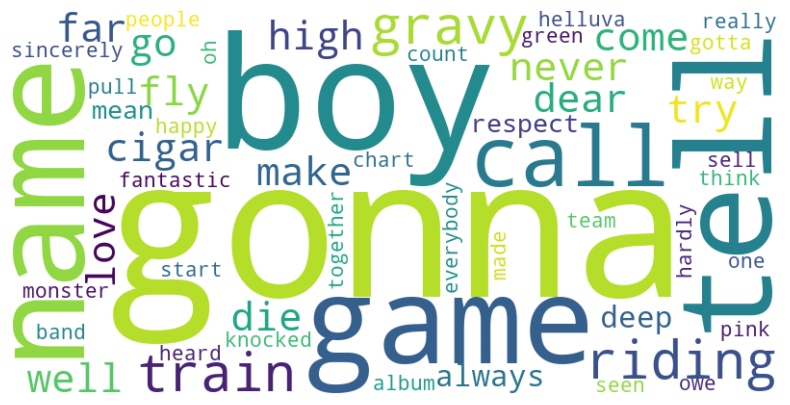

In [17]:
# Retrieve lyrics and generate word cloud

print(f"Retrieving lyrics for track '{track_dropdown.value}'")

from wordcloud import WordCloud
import matplotlib.pyplot as plt

track_name = track_dropdown.value

try:
  lyrics = get_track_lyrics(artist_name, track_name)

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics.lower())
  
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
except:
  print("Error retrieving lyrics")